<a href="https://colab.research.google.com/github/maxwellowusu/Accra_slum_map/blob/master/Lagos_ML_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

**Mount G-drive to notebook**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install missing packages if needed** 

In [2]:
!pip install rasterio
!pip install gpytorch

     |████████████████████████████████| 19.3 MB 4.8 MB/s 
     |████████████████████████████████| 310 kB 5.3 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=077016420aae32f1c1ea1fddacfce8b2534452d5fd53cecc6c77e0191c989355
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


**Import packages**

In [3]:
import numpy as np
from sklearn import preprocessing
import torch
import pandas as pd
import rasterio
from rasterio.plot import show
import gpytorch
import gdal
import glob
import os

**Importing contextual features from multiple folders**

In [4]:
# set main path. 
# end path with /
Path = '/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/spfea_contextual_features/'
filelist = os.listdir(Path)

#Make empty list to store all paths to subdirectories in.
Path2 = []
for x in filelist:
    if x.startswith('fourier', 0, 10):
        Path2.append(Path + x+ '/')
    # if x.startswith('gabor', 0, 10):
    #     Path2.append(Path + x+ '/')
    # if x.startswith('hog', 0, 10):
    #     Path2.append(Path + x+ '/')
    # if x.startswith('lac', 0, 10):
    #     Path2.append(Path + x+ '/')
    # if x.startswith('ibpm', 0, 10):
    #     Path2.append(Path + x+ '/')
    # if x.startswith('isr', 0, 10):
    #     Path2.append(Path + x+ '/')
    # if x.startswith('mean', 0, 10):
    #     Path2.append(Path + x+ '/')
    # if x.startswith('ndvi', 0, 10):
    #     Path2.append(Path + x+ '/')
    # if x.startswith('orb', 0, 10):
    #     Path2.append(Path + x+ '/')
    # if x.startswith('pantex', 0, 10):
    #     Path2.append(Path + x+ '/')
    # if x.startswith('sfs', 0, 10):
    #     Path2.append(Path + x+ '/')
        
file_list3 = []
for i in Path2:
    filelist2 = os.listdir(i)
    for j in filelist2:
        if j.endswith('.tif'):
            file = i+j
            file_list3.append(file)

print(file_list3)

['/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/spfea_contextual_features/fourier/fourier_sc31_variance.tif', '/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/spfea_contextual_features/fourier/fourier_sc51_mean.tif', '/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/spfea_contextual_features/fourier/fourier_sc51_variance.tif', '/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/spfea_contextual_features/fourier/fourier_sc71_mean.tif', '/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/spfea_contextual_features/fourier/fourier_sc71_variance.tif', '/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/spfea_contextual_features/fourier/fourier_sc31_mean.tif']


**Converting .tif files to .vrt**

In [5]:
vrt_options = gdal.BuildVRTOptions(separate= True)
test_vrt = gdal.BuildVRT('test3.vrt', file_list3 , options=vrt_options)

test_vrt = None

# with rasterio.open('test2.vrt') as raster_vrt:

#     rasterio.plot.show(raster_vrt)

**Read .vrt using rasterio**

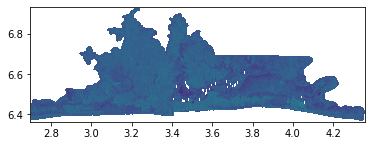

(6, 6850, 19930)

In [6]:
fp = '/content/test3.vrt'
covariate_features = rasterio.open(fp)
data_loc = covariate_features.read()
data_loc = np.array(data_loc)
#Print data shape
show(covariate_features)
data_loc.shape

In [7]:
# We now process our predictors. We remove categorial variables (small fix for now) and normalize continuous variables.
data_glob = covariate_features.read()
#Get data extent
n = data_glob.shape[0]
h = data_glob.shape[1]
w = data_glob.shape[2]

data_glob = data_glob.reshape(n,h*w)
#Scale data
scaler = preprocessing.StandardScaler().fit(data_glob)
data_glob = scaler.transform(data_glob)
data_glob = data_glob.reshape(n,h,w)
#Exclude categorical variables
#data_glob = np.delete(data_glob,np.array(np.where(unqs<14))[0],axis=0)
n = data_glob.shape[0]
#Print data shape
data_glob.shape

(6, 6850, 19930)

**Resampling training data** 

In [9]:
# resampling training data 
tr = '/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/lag_training_data/lag_training_2021.tif'
g = gdal.Warp("resample.tif", tr, xRes =  0.00008333333300000001029, yRes= 0.00008333333300000003198, resampleAlg= 'bilinear', format="GTiff",
              options=["COMPRESS=LZW", "TILED=YES"]) # if you want
g = None # Close file and flush to disk


**Load training data**

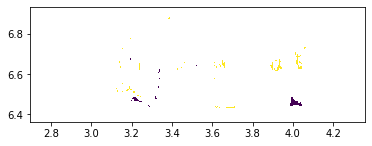

(1, 6850, 19930)

In [10]:
# Next, we read and process our outcome variable  𝑦
fp = '/content/resample.tif'
Tr = rasterio.open(fp)
data_loc = Tr.read()
data_loc = np.array(data_loc)
#Print data shape
show(Tr)
data_loc.shape

In [11]:
(unique, counts) = np.unique(data_loc, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[     -999, 131764500],
       [        0,   1516494],
       [        1,     34054],
       [        2,   3205452]])

In [12]:
#Combine data
y = np.array(data_loc[0,...]).reshape(1,h,w)
x = data_glob
data = np.concatenate((y,x),axis=0)
#Print data shape
data.shape

(7, 6850, 19930)

**Split data into train and test set**

In [13]:
# We now split our data into training and test set
data = data.reshape(data.shape[0], -1)
#Train data
data_train = data[:, ~np.isnan(data).any(axis=0)]
#data_train = data_train[:, (data_train!=-999).any(axis=0)]
data_train = data_train[:, data_train[0,...]!=-999]
y = data_train[0,...]
x = data_train[1:,...]
#Test data
#data_test = data[:, np.isnan(data).any(axis=0)]
#data_test = data_test[:, (data_test==-999).any(axis=0)]
#data_test = data_test[:,  data_test[0,...]==-999]
#y_test = data_test[0,...]
#x_test = data_test[1:,...]
#Let's check the shape
print(data_train.shape)
#print(data_test.shape)

(7, 4756000)


In [14]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[0.000000e+00, 1.516494e+06],
       [1.000000e+00, 3.405400e+04],
       [2.000000e+00, 3.205452e+06]])

In [15]:
# Split into train / test data.
from sklearn.model_selection import train_test_split
test_size = 0.3
x = np.transpose(x)
y = np.transpose(y)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=test_size)

**Modeling **

In [16]:
# Now we're ready for modeling!
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

# model_lr = LogisticRegression(multi_class="multinomial", max_iter = 50000)
# model_lr.fit(x_train, y_train)

# pred = model_lr.predict(x_train)
# acc_train = accuracy_score(y_train, pred)
# print(("Train accuracy: %f") % (acc_train))

# pred = model_lr.predict(x_test)
# acc_test = accuracy_score(y_test, pred)
# print(("Test accuracy: %f") % (acc_test))

In [ ]:
cm = confusion_matrix(y_test, pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

array([0.31800274, 0.        , 0.89084886])

In [17]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

pred = model_rf.predict(x_train)
acc_train = accuracy_score(y_train, pred)
print(("Train accuracy: %f") % (acc_train))

pred = model_rf.predict(x_test)
acc_test = accuracy_score(y_test, pred)
print(("Test accuracy: %f") % (acc_test))

Train accuracy: 0.999992
Test accuracy: 0.694545


In [18]:
cm = confusion_matrix(y_test, pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

array([3.87480577e-01, 1.93255387e-04, 8.47032227e-01])

In [ ]:
model_gb = GradientBoostingClassifier()
model_gb.fit(x_train, y_train)

pred = model_gb.predict(x_train)
acc_train = accuracy_score(y_train, pred)
print(("Train accuracy: %f") % (acc_train))

pred = model_gb.predict(x_test)
acc_test = accuracy_score(y_test, pred)
print(("Test accuracy: %f") % (acc_test))

In [ ]:
cm = confusion_matrix(y_test, pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

In [ ]:
# Make predition 
map_x = np.transpose(data[1:,...])
map_x = np.nan_to_num(map_x)
pred_map = model_rf.predict(map_x)
pred_map = pred_map.reshape(685, 1993)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from matplotlib import colors

cmap = colors.ListedColormap(['green', 'blue', 'yellow'])
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
fig = plt.figure(figsize = (13,9)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ims = ax.imshow(pred_map, interpolation='none')
#img = plt.imshow(pred_map, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
ax.set_ylim(300,700)
ax.set_xlim(500,1000)
ax.axis('off')
ax.invert_yaxis()

In [ ]:
map_x = np.transpose(data[1:,...])
map_x = np.nan_to_num(map_x)
pred_map = model_lr.predict_proba(map_x)
pred_map = pred_map.reshape(685, 1993, 3)

# tell imshow about color map so that only set colors are used
fig = plt.figure(figsize = (13,9)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ims = ax.imshow(pred_map[:,:,1])
#img = plt.imshow(pred_map, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
ax.set_ylim(300,700)
ax.set_xlim(500,1000)
ax.set_title('Predicted Deprivation Probabilities for Lagos (Model: Logistic Regression)')
ax.axis('off')
ax.invert_yaxis()

In [ ]:
pred_map = model_rf.predict_proba(map_x)
pred_map = pred_map.reshape(685, 1993, 3)

# tell imshow about color map so that only set colors are used
fig = plt.figure(figsize = (13,9)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ims = ax.imshow(pred_map[:,:,1])
#img = plt.imshow(pred_map, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
ax.set_ylim(300,700)
ax.set_xlim(500,1000)
ax.set_title('Predicted Deprivation Probabilities for Lagos (Model: Random Forest)')
ax.axis('off')
ax.invert_yaxis()

In [ ]:
pred_map = model_gb.predict_proba(map_x)
pred_map = pred_map.reshape(685, 1993, 3)

# tell imshow about color map so that only set colors are used
fig = plt.figure(figsize = (13,9)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ims = ax.imshow(pred_map[:,:,1])
#img = plt.imshow(pred_map, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
ax.set_ylim(300,700)
ax.set_xlim(500,1000)
ax.set_title('Predicted Deprivation Probabilities for Lagos (Model: Gradient Boosting)')
ax.axis('off')
ax.invert_yaxis()

In [ ]:
# Get features of importance 

In [ ]:
feature_names = ["fs_dist_fs_2020"
,"fs_dist_hf_2019"
,"fs_dist_hf1_2020"
,"fs_dist_market_2020"
,"fs_dist_mosques_2017"
,"fs_dist_school_2020"
,"fs_dist_school1_2018"
,"fs_dist_well_2018"
,"in_electric_dist_2020"
,"in_dist_rd_2016"
,"in_dist_rd_intersect_2016"
,"in_dist_waterway_2016"
,"in_night_light_2016"
,"ph_base_water_2010"
,"ph_bio_dvst_2015"
,"ph_climate_risk_2020"
,"ph_dist_aq_veg_2015"
,"ph_dist_art_surface_2015"
,"ph_dist_bare_2015"
,"ph_dist_cultivated_2015"
,"ph_dist_herb_2015"
,"ph_dist_inland_water_2018"
,"ph_dist_open_coast_2020"
,"ph_dist_riv_network_2007"
,"ph_dist_shrub_2015"
,"ph_dist_sparse_veg_2015"
,"ph_dist_woody_tree_2015"
,"ph_gdmhz_2005"
,"ph_grd_water_2000"
,"ph_hzd_index_2011"
,"ph_land_c1_2019"
,"ph_land_c2_2020"
,"ph_max_tem_2019"
,"ph_ndvi_2019"
,"ph_pm25_2016"
,"ph_slope_2000"
,"po_pop_fb_2018"
,"po_pop_un_2020"
,"ses_an_visits_2016"
,"ses_child_stunted_2018"
,"ses_dpt3_2018"
,"ses_hf_delivery_2018"
,"ses_impr_water_src_2016"
,",ses_ITN_2016"
,"ses_m_lit_2018"
,"ses_measles_2018"
,"ses_odef_2018"
,"ses_pfpr_2017"
,"ses_preg_2017"
,"ses_unmet_need_2018"
,"ses_w_anemia_2018"
,"ses_w_lit_2018"
,"sh_dist_conflict_2020"
,"sh_dist_mnr_pofw_2019"
,"sh_dist_pofw_2019"
,"sh_ethno_den_2020"
,"sh_pol_relev_ethnic_gr_2019"
,"uu_bld_count_2020"
,"uu_bld_den_2020"
,"ho_impr_housing_2015"
,"uu_urb_bldg_2018"]

In [ ]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

import pandas as pd
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize = (15,7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
fp = '/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/lag_covariate_compilation/lag_covariates_compilation.tif'
img = rasterio.open(fp)
data_glob = img.read()
#Get data extent
n = data_glob.shape[0]
h = data_glob.shape[1]
w = data_glob.shape[2]
data_glob = data_glob.reshape(n,h*w)
#Scale data
scaler = preprocessing.StandardScaler().fit(data_glob)
data_glob = scaler.transform(data_glob)
data_glob = data_glob.reshape(n,h,w)
#Exclude categorical variables
#data_glob = np.delete(data_glob,np.array(np.where(unqs<14))[0],axis=0)
n = data_glob.shape[0]

fp = '/content/drive/MyDrive/Project_data_IDEAMAPS/lagos/lag_training_data/lag_training_2021.tif'
img = rasterio.open(fp)
data_loc = img.read()
data_loc = np.array(data_loc)
#Combine data
y = np.array(data_loc[0,...]).reshape(1,h,w)
x = data_glob
data = np.concatenate((y,x),axis=0)
data = data.reshape(data.shape[0], -1)
#Train data
data_train_lagos = data[:, ~np.isnan(data).any(axis=0)]
#data_train = data_train[:, (data_train!=-999).any(axis=0)]
data_train_lagos = data_train_lagos[:, data_train_lagos[0,...]!=-999]
y_lagos = data_train_lagos[0,...]
x_lagos = data_train_lagos[1:,...]

common_feat_lagos = [0,5,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,38,39,40,41,42,43,44,45,46,47,48,49,51,53,54,55,57,58]
x_lagos = x_lagos[common_feat_lagos,...]
x_lagos = np.transpose(x_lagos)
print(x_lagos.shape)